# EDA: Анализ данных по аренде самокатов

**Фамилия, имя:** Текеев Баир  
**Тип работы:** Разведочный анализ данных (Exploratory Data Analysis)  
**Датасет:** `kicksharing.csv`  


**Цель анализа:** понять структуру датасета и особенности данных, выявить ошибки и заметить аномалии, на которые стоит обратить внимание при формулировке гипотез и выбора моделей.



In [4]:
# нужные пакеты pandas, numpy, matplotlib, seaborn, missingno; их установка:
!pip install -U pandas numpy matplotlib seaborn missingno tqdm 


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\lancy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Импорт библиотек и базовые настройки


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (8, 4)
sns.set_style("whitegrid")



## Загрузка данных и представление

In [59]:
PATH = "kicksharing.csv"
df_raw = pd.read_csv(PATH, low_memory=False)

print(f"Строк: {df_raw.shape[0]:,}  |  Столбцов: {df_raw.shape[1]}")
df_raw.head()

Строк: 396,749  |  Столбцов: 20


,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,NaN
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41.000000,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,NaN
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09.000000,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,NaN
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40.000000,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,NaN


### Оптимизация для экономия памяти


In [60]:
for col in ["gender_cd", "education_level_cd", "marital_status_cd",
            "lvn_state_nm", "transport_model"]:
    df_raw[col] = df_raw[col].astype("category")

float_cols = df_raw.select_dtypes("float64").columns
df_raw[float_cols] = df_raw[float_cols].astype("float32")

print("RAM after downcast:", df_raw.memory_usage(deep=True).sum()/1e6, "MB")


RAM after downcast: 145.24163 MB


## Общая структура и типы данных


In [61]:
df_raw.info()
df_raw.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   order_rk                 396749 non-null  int64   
 1   party_rk                 396749 non-null  int64   
 2   gender_cd                393828 non-null  category
 3   age                      396749 non-null  int64   
 4   education_level_cd       190059 non-null  category
 5   marital_status_cd        217729 non-null  category
 6   lvn_state_nm             362572 non-null  category
 7   minute_cost              396749 non-null  float32 
 8   activation_cost          396749 non-null  float32 
 9   hold_amount              396749 non-null  float32 
 10  transport_model          396749 non-null  category
 11  distance_km              396749 non-null  float32 
 12  created_dttm             396749 non-null  object  
 13  book_start_dttm          396749 non-null  ob

,count,mean,std,min,25%,50%,75%,max
order_rk,396749.0,2.892236e+08,3.813458e+07,2.526112e+08,2.618150e+08,2.704367e+08,3.432678e+08,3.562528e+08
party_rk,396749.0,5.988426e+08,3.311675e+08,1.471700e+04,2.962323e+08,6.110092e+08,8.646921e+08,1.301075e+09
age,396749.0,3.154401e+01,9.434545e+00,1.200000e+01,2.400000e+01,3.100000e+01,3.700000e+01,9.400000e+01
minute_cost,396749.0,7.288688e+00,1.289492e+00,1.500000e+00,6.490000e+00,7.490000e+00,8.220000e+00,1.999000e+01
activation_cost,396749.0,4.259323e+01,1.198997e+01,0.000000e+00,3.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
hold_amount,396749.0,2.999838e+02,1.939153e+00,8.000000e+01,3.000000e+02,3.000000e+02,3.000000e+02,5.000000e+02
distance_km,396749.0,3.681030e+00,1.418624e+02,0.000000e+00,9.410537e-01,1.729883e+00,3.063694e+00,5.601264e+04
book_time_zone_cd,396749.0,3.536155e+00,1.209075e+00,0.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,1.200000e+01
nominal_price_rub_amt,396749.0,1.276477e+02,1.001224e+02,0.000000e+00,8.084000e+01,1.039400e+02,1.421000e+02,5.627640e+03
loyalty_accrual_rub_amt,366992.0,3.751612e+01,7.520856e+01,-1.619400e+02,1.124000e+01,1.873000e+01,3.506000e+01,3.185000e+03


### Убираем ID-столбцы

`order_rk` и `party_rk` — уникальные идентификаторы заказов и пользователей, они не влияют на этот анализ => убираем.


In [78]:
df = df_raw.drop(columns=["order_rk", "party_rk"])


### Приведение временных столбцов к `datetime`


In [79]:
date_cols = [c for c in df.columns if "date" in c.lower() or "dttm" in c.lower() or "time" in c.lower() or "ts" in c.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")
print("Обнаружены и преобразованы к datetime следующие колонки:")
print(date_cols)
df[date_cols].head()
if "party_rk" in df.columns and "book_start_dttm" in df.columns:
    dup_mask = df.duplicated(subset=["party_rk", "book_start_dttm"])
    print("Дубликатов найдено:", dup_mask.sum())
    df = df[~dup_mask]
else:
    print("Колонка party_rk или book_start_dttm не найдена")
print("Дубликатов найдено:", dup_mask.sum())
df = df[~dup_mask]
q1, q3 = df["distance_km"].quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
print(f"Оставляем поездки с расстоянием от {lo:.2f} до {hi:.2f} км")
df = df[df["distance_km"].between(lo, hi)]


Обнаружены и преобразованы к datetime следующие колонки:
['created_dttm', 'book_start_dttm', 'book_end_dttm', 'book_time_zone_cd', 'local_book_start_dttm']
Колонка party_rk или book_start_dttm не найдена
Дубликатов найдено: 0
Оставляем поездки с расстоянием от -2.24 до 6.25 км


In [80]:
date_cols = [
    "created_dttm",
    "book_start_dttm",
    "book_end_dttm",
    "local_book_start_dttm",
]

for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

df[date_cols].head()


,created_dttm,book_start_dttm,book_end_dttm,local_book_start_dttm
0,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,2024-08-07 11:47:29.325252
1,2024-10-17 14:57:20,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,2024-10-17 14:57:24.586000
2,2024-09-19 05:31:41,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,2024-09-19 07:34:59.476000
3,2024-10-04 16:05:09,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,2024-10-04 16:05:13.162000
4,2024-07-10 06:57:40,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,2024-07-10 06:57:43.017125


## Анализ пропусков


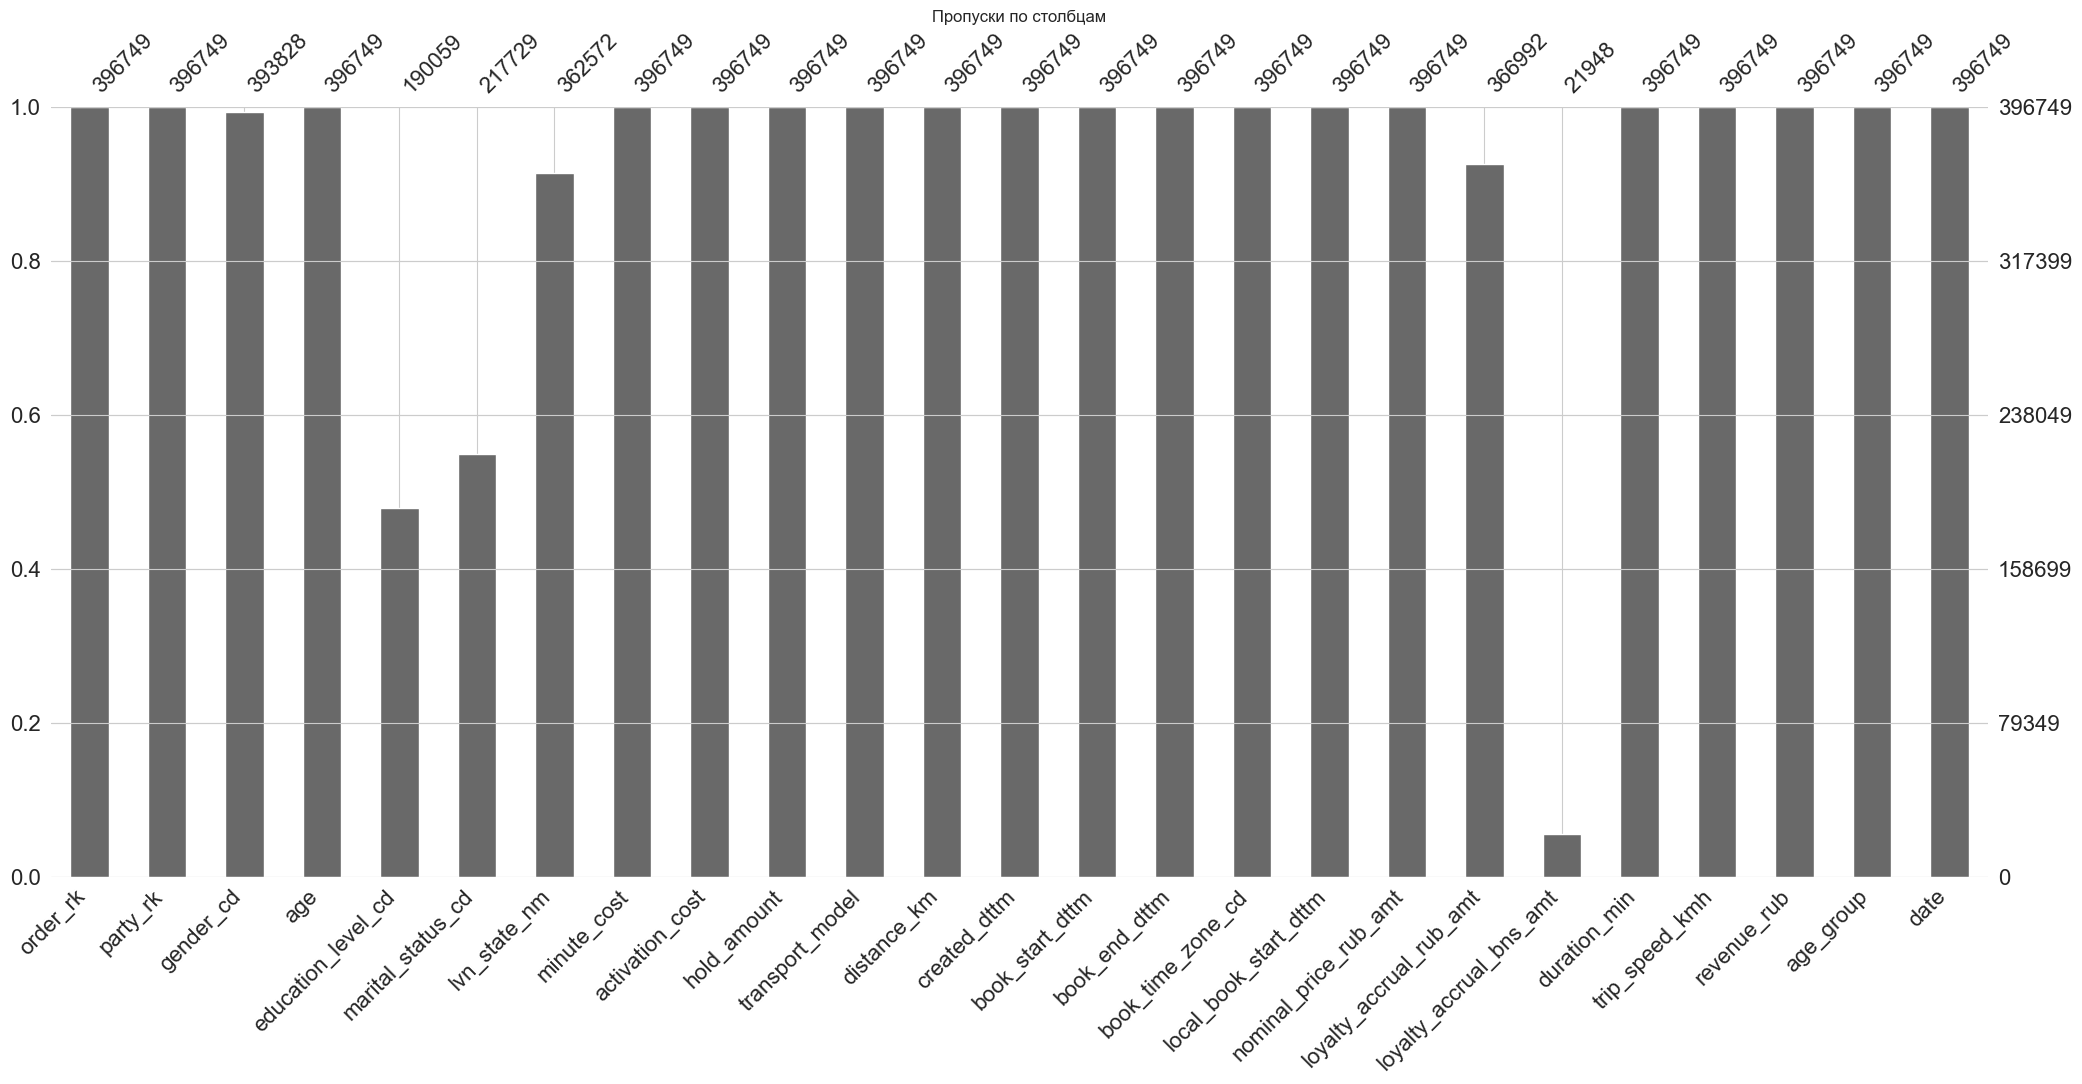

loyalty_accrual_bns_amt    94.468039
education_level_cd         52.095910
marital_status_cd          45.121727
lvn_state_nm                8.614262
loyalty_accrual_rub_amt     7.500208
gender_cd                   0.736234
party_rk                    0.000000
age                         0.000000
order_rk                    0.000000
activation_cost             0.000000
dtype: float64

In [108]:
msno.bar(df)
plt.title("Пропуски по столбцам")
plt.show()

(df.isna().mean()*100).sort_values(ascending=False).head(10)


## Фиксация аномалий и очистка

Что убираем:
* **distance_km** > 100 км.  
* **duration_min** < 1 мин или > 240 мин.  
* Столбцы c `NaN` > 95 % удаляем.

Создаём `df_clean` для дальнейших графиков, а подозрительные записи сохраняем отдельно в `df_anomaly`.


In [82]:
df["duration_min"] = ((df["book_end_dttm"] - df["book_start_dttm"]).dt.total_seconds() / 60)
anomaly_mask = (
    (df["distance_km"] > 100) |
    (df["duration_min"] < 1) |
    (df["duration_min"] > 240))

df_anomaly = df[anomaly_mask].copy()
df_clean   = df[~anomaly_mask].copy()
too_empty = df_clean.isna().mean() > 0.95
df_clean  = df_clean.loc[:, ~too_empty]
print("Чистых строк:", df_clean.shape[0], " Аномальных строк:", df_anomaly.shape[0])
df = df_raw.copy()  



Чистых строк: 361546  Аномальных строк: 8708


### Проверяем данные 

Ниже снова вывод `.describe()` для очищенного набора.


In [97]:
df_clean.describe().T


,count,mean,min,25%,50%,75%,max,std
age,361546.0,31.543151,12.0,24.0,31.0,37.0,94.0,9.406839
minute_cost,361546.0,7.310304,1.5,6.49,7.49,8.29,19.99,1.28662
activation_cost,361546.0,42.722256,0.0,30.0,50.0,50.0,50.0,11.974998
hold_amount,361546.0,299.987091,80.0,300.0,300.0,300.0,500.0,1.74803
distance_km,361546.0,1.971817,0.0,0.940361,1.648046,2.731926,6.247511,1.394242
created_dttm,361546,2024-08-18 17:02:18.747390208,2024-04-09 12:23:51,2024-07-20 21:54:37,2024-08-23 05:59:57.500000,2024-09-17 00:06:09.500000,2024-10-21 17:18:04,NaN
book_start_dttm,361546,2024-08-18 17:02:24.880476672,2024-04-09 12:23:56.253700,2024-07-20 21:54:42.135152896,2024-08-23 06:00:02.468704512,2024-09-17 00:06:15.351249920,2024-10-21 17:18:07.715000,NaN
book_end_dttm,361546,2024-08-18 17:12:13.601916416,2024-04-09 12:25:18.952234,2024-07-20 22:08:29.795662336,2024-08-23 06:07:19.761253120,2024-09-17 00:22:43.830879488,2024-10-21 17:23:06.640943,NaN
book_time_zone_cd,361546,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000012,NaN
local_book_start_dttm,361546,2024-08-18 17:33:51.598073344,2024-04-09 12:23:56.253700,2024-07-20 22:17:50.418224640,2024-08-23 06:27:51.049492992,2024-09-17 01:35:11.430000128,2024-10-21 21:13:43.199000,NaN


## Добавляем новые значения


### Расчёт продолжительности поездки, группировка по возрасту

In [101]:
df["book_start_dttm"] = pd.to_datetime(df["book_start_dttm"], errors="coerce")
df["book_end_dttm"] = pd.to_datetime(df["book_end_dttm"], errors="coerce")

df["duration_min"] = ((df["book_end_dttm"] - df["book_start_dttm"]).dt.total_seconds() / 60)
df["trip_speed_kmh"] = df["distance_km"] / (df["duration_min"] / 60)
df["revenue_rub"] = df["nominal_price_rub_amt"].fillna(0) - df["loyalty_accrual_rub_amt"].fillna(0)

bins = [0, 18, 25, 35, 45, 60, np.inf]
labels = ["<=18", "19-25", "26-35", "36-45", "46-60", "60+"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)


## Распределения числовых признаков 


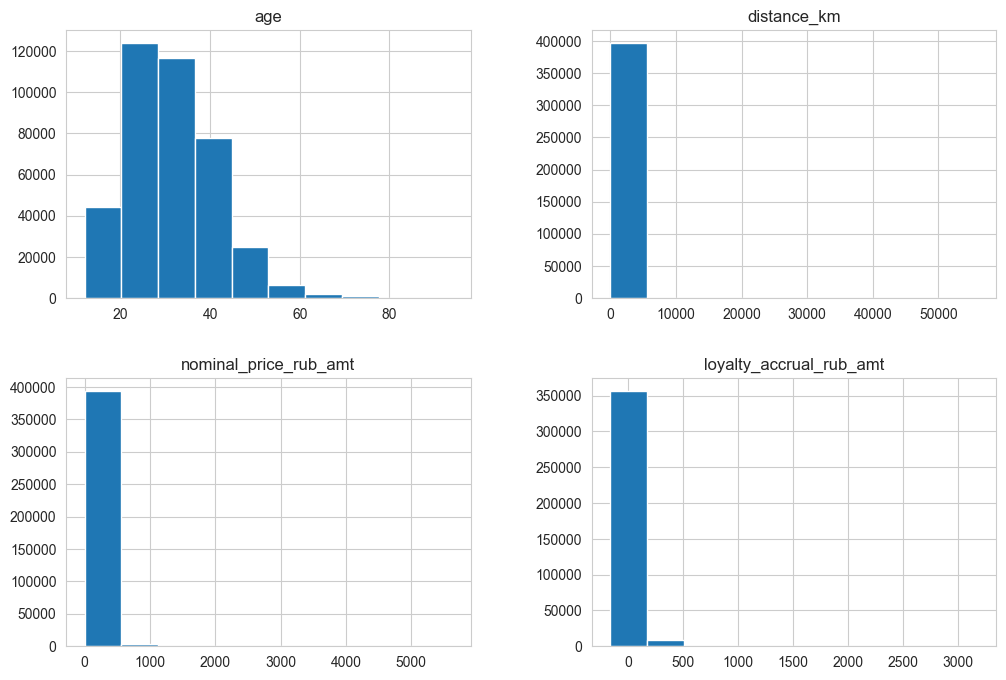

In [99]:
num_cols = ['age', 'distance_km', 'nominal_price_rub_amt', 'loyalty_accrual_rub_amt']
df[num_cols].hist(figsize=(12, 8))
plt.show()

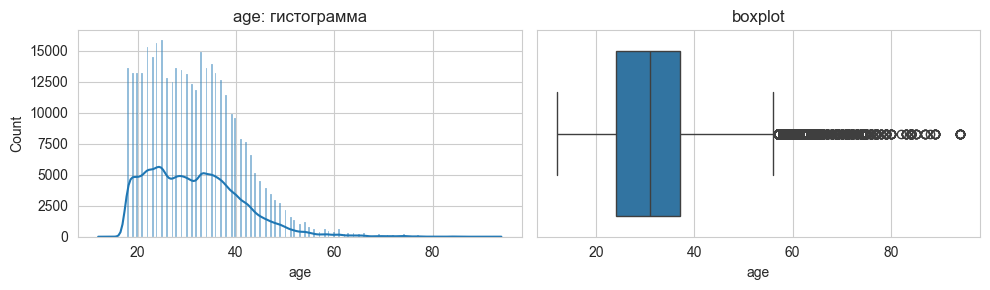

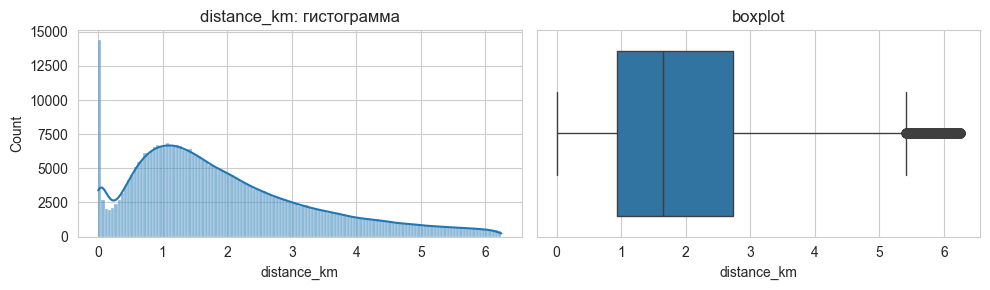

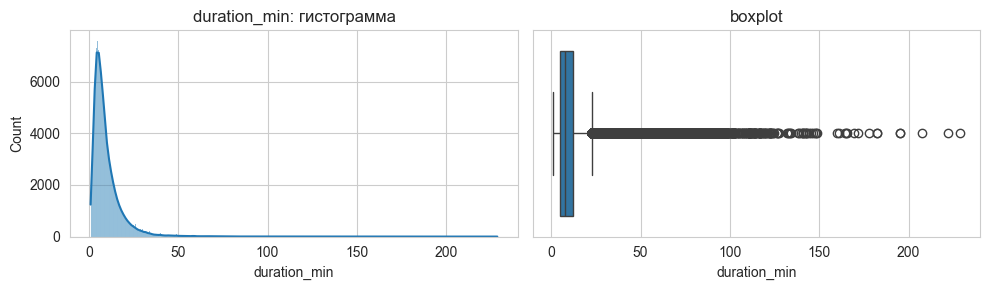

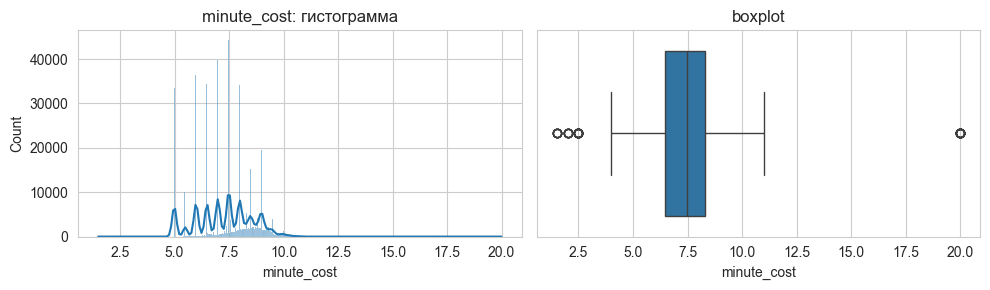

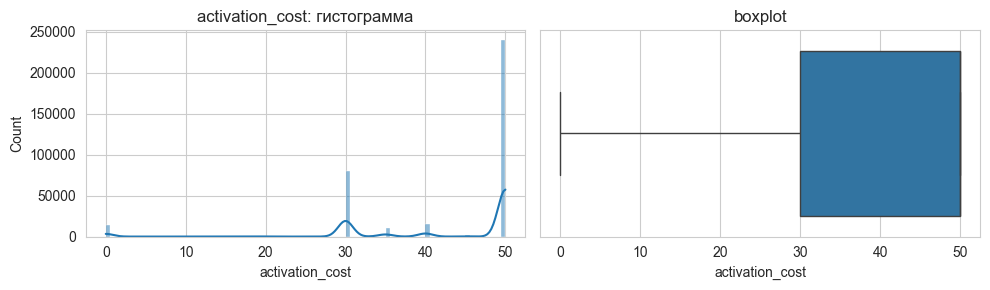

In [100]:
num_cols = ["age", "distance_km", "duration_min", "minute_cost", "activation_cost"]

for col in num_cols:
    if col in df_clean.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        sns.histplot(df_clean[col].dropna(), kde=True, ax=ax1)
        sns.boxplot(x=df_clean[col], ax=ax2)
        ax1.set_title(f"{col}: гистограмма"); ax2.set_title("boxplot")
        plt.tight_layout(); plt.show()


## Частотный анализ категориальных признаков


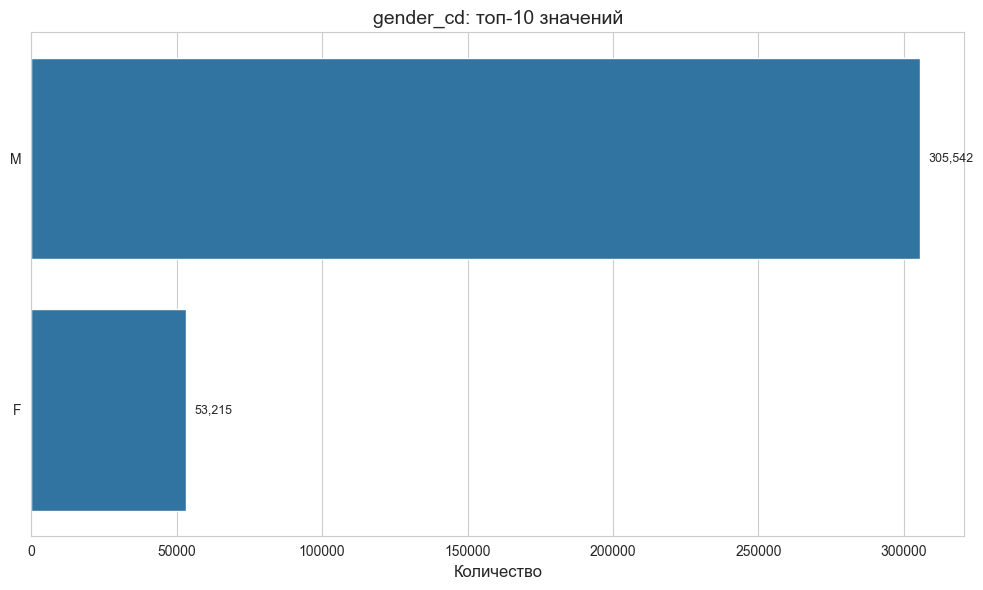

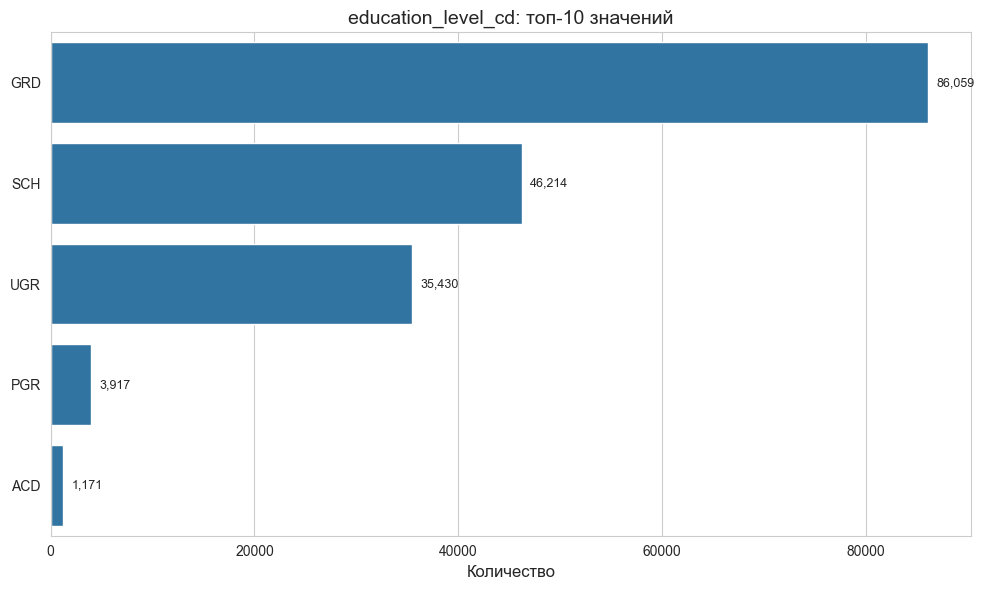

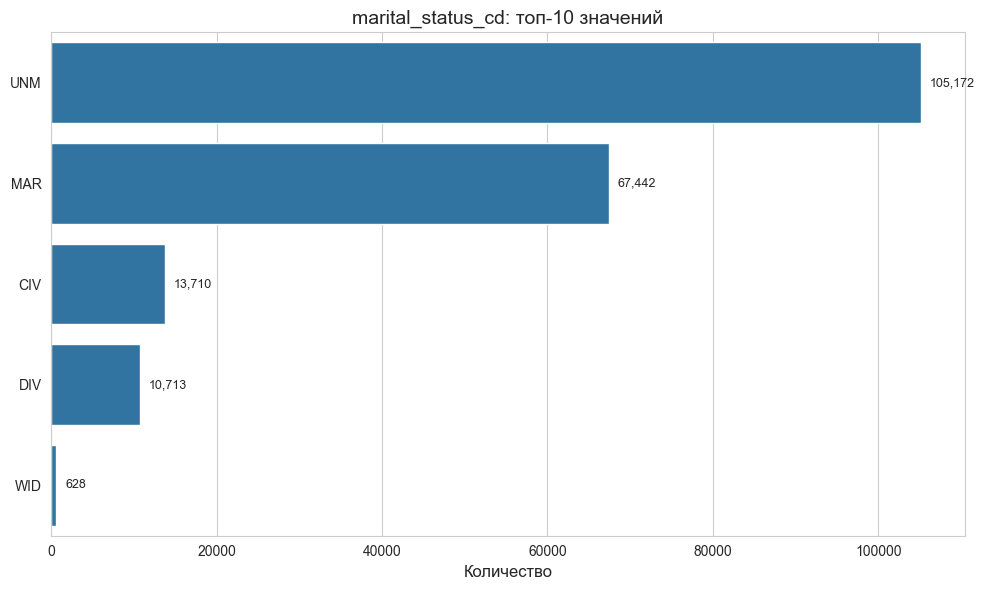

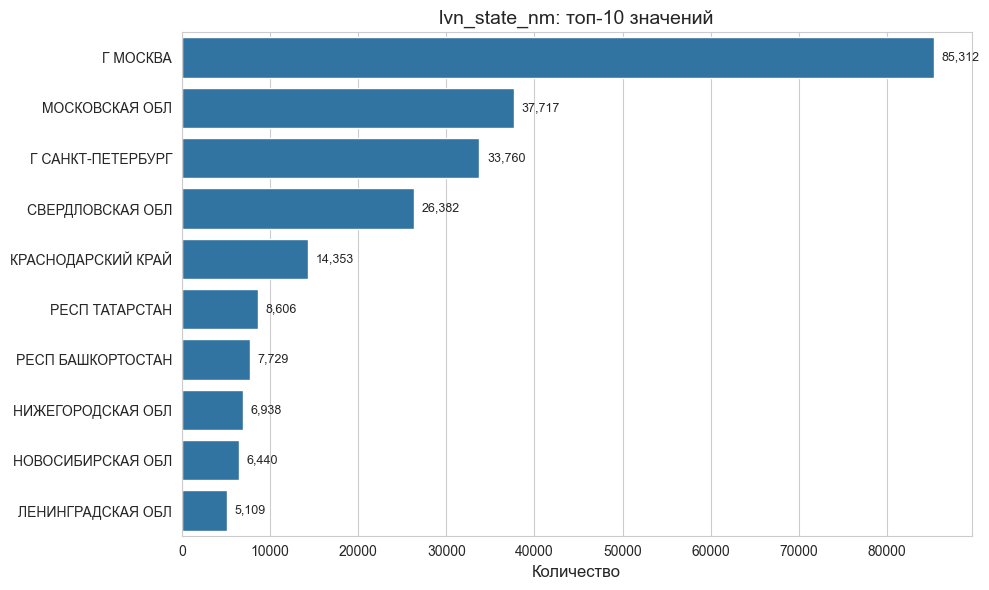

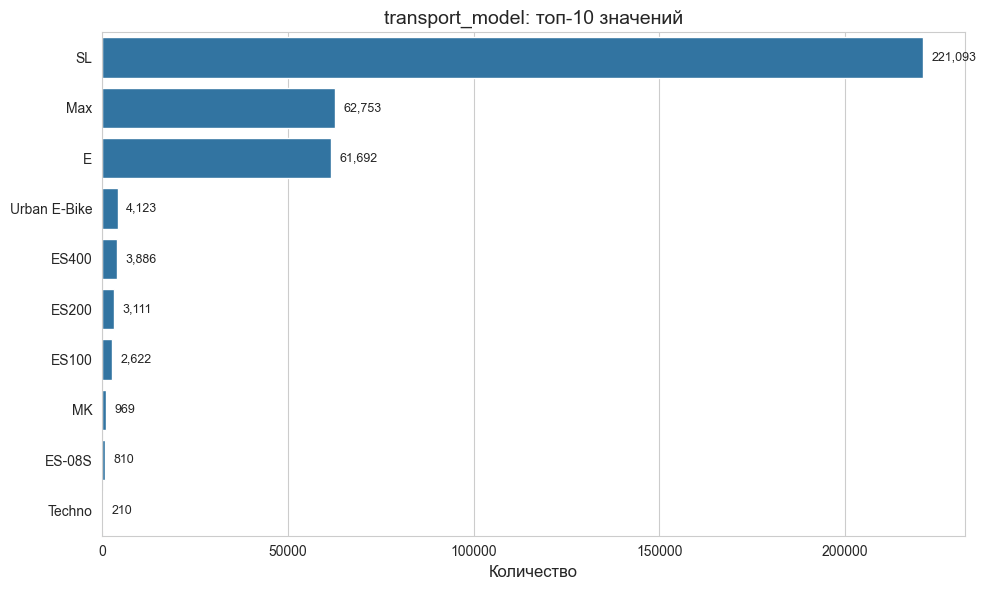

In [102]:
import textwrap

cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns

for col in cat_cols:
    top = df_clean[col].value_counts().head(10)
    
    # 1. Wrap labels: разбиваем текст длиной >20 на несколько строк
    wrapped_labels = [
        "\n".join(textwrap.wrap(str(label), width=20))
        for label in top.index
    ]
    
    # 2. Рисуем
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=top.values, y=wrapped_labels, orient="h", ax=ax)
    
    # 3. Подписи над барами
    for i, v in enumerate(top.values):
        ax.text(v + max(top.values)*0.01, i, f"{v:,}", va='center', fontsize=9)
    
    ax.set_title(f"{col}: топ-10 значений", fontsize=14)
    ax.set_xlabel("Количество", fontsize=12)
    ax.set_ylabel("")  # метки уже на y
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    plt.tight_layout()
    plt.show()


## Корреляция с фильтрацией (p-value)


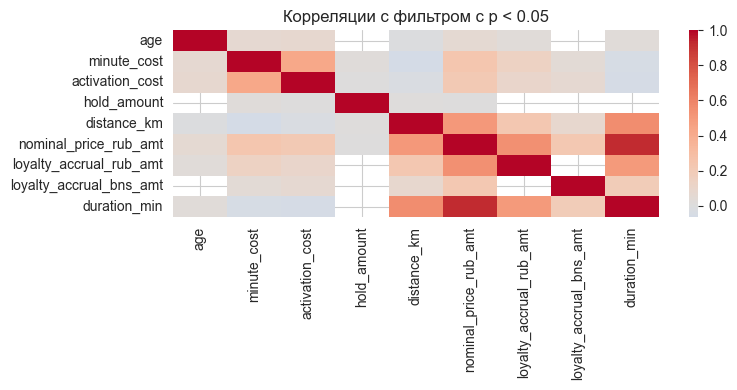

In [103]:
df_for_corr = df_clean.select_dtypes(include=["number"]).copy()
import scipy.stats as st
def pval(x, y):
    return st.pearsonr(x, y)[1]

corr = df_for_corr.corr()
pvals = df_for_corr.corr(method=pval) - np.eye(len(corr))
mask = (pvals < 0.05)

sns.heatmap(corr.where(mask), cmap="coolwarm", center=0)
plt.title("Корреляции c фильтром с p < 0.05")
plt.tight_layout(); plt.show()


## Корреляция без фильрации


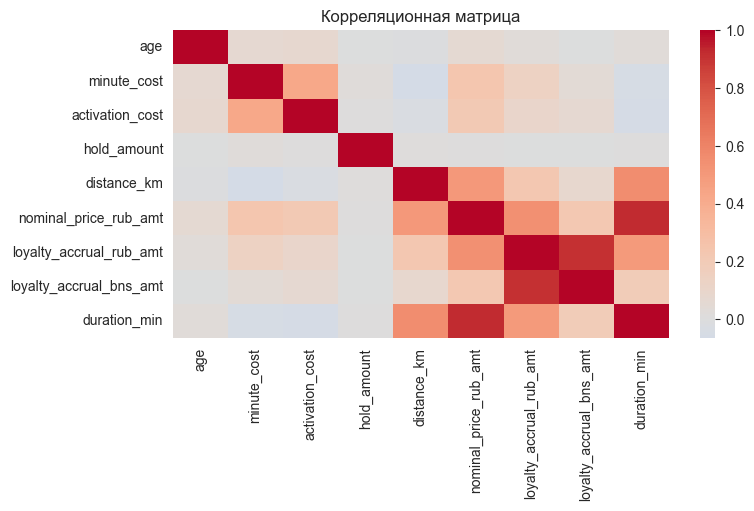

In [104]:
df_for_corr = df_clean.drop(columns=['order_rk', 'party_rk'], errors='ignore')
corr = df_for_corr.select_dtypes(include=['number']).corr()
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Корреляционная матрица')
plt.show()



## Динамика поездок и выручки по дням


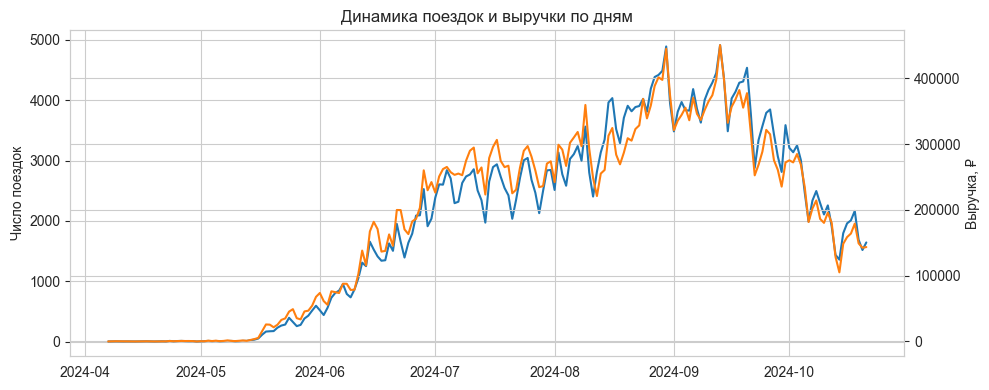

In [105]:
df["book_start_dttm"] = pd.to_datetime(df["book_start_dttm"], errors="coerce")
df["date"] = df["book_start_dttm"].dt.date
daily_stats = (
    df.groupby("date")
      .agg(trips=("order_rk", "count"),
           revenue=("revenue_rub", "sum"))
      .reset_index()
)

fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()
ax1.plot(daily_stats["date"], daily_stats["trips"], label="Поездки", color="tab:blue")
ax2.plot(daily_stats["date"], daily_stats["revenue"], label="Выручка", color="tab:orange")

ax1.set_ylabel("Число поездок")
ax2.set_ylabel("Выручка, ₽")
plt.title("Динамика поездок и выручки по дням")
plt.tight_layout(); plt.show()


## Временные паттерны использования


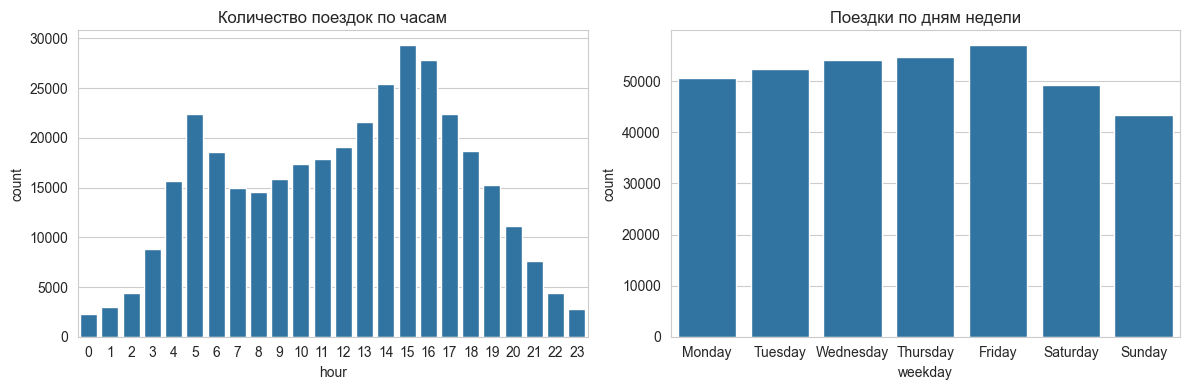

In [106]:
if "book_start_dttm" in df_clean.columns:
    df_clean["hour"] = df_clean["book_start_dttm"].dt.hour
    df_clean["weekday"] = df_clean["book_start_dttm"].dt.day_name()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(x="hour", data=df_clean, ax=ax[0])
    ax[0].set_title("Количество поездок по часам")

    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    sns.countplot(x="weekday", data=df_clean, order=order, ax=ax[1])
    ax[1].set_title("Поездки по дням недели")
    plt.tight_layout(); plt.show()


In [107]:
print("Итоговая сводка EDA\n")

print("Показатели:")
print(f"- Строк в исходном датасете: {df_raw.shape[0]}")
print(f"- Строк после очистки: {df_clean.shape[0]}")
print(f"- Количество аномальных записей: {df_anomaly.shape[0]}")
print(f"- Признаков после удаления пустых: {df_clean.shape[1]}")
print(f"- Средний процент пропусков: {round(df_clean.isna().mean().mean()*100, 2)}%\n")

print("Ключевые наблюдения:")
print("1. В исходных данных есть дистанции более 100 км и поездки более 4 часов, вероятно, являются ошибками.")
print("2. Финансовые поля 'activation_cost' и 'hold_amount' фиксированы (50 рублей и 300 рублей).")
print("3. Подавляющее большинство поездок длится от 5 до 30 минут и от 1 до 5 километров.")
print("4. Пик спроса наблюдается (13-16) и в пятницу и четверг.")


print("Возможно, стоит:")
print("- Проверить логику завершения сессий, чтобы снизить количество слишком длинных поездок.")
print("- Разделить отчетность по регионам (Москва / остальные), так как данные сильно несбалансированы.")

Итоговая сводка EDA

Показатели:
- Строк в исходном датасете: 396749
- Строк после очистки: 361546
- Количество аномальных записей: 8708
- Признаков после удаления пустых: 21
- Средний процент пропусков: 9.87%

Ключевые наблюдения:
1. В исходных данных есть дистанции более 100 км и поездки более 4 часов, вероятно, являются ошибками.
2. Финансовые поля 'activation_cost' и 'hold_amount' фиксированы (50 рублей и 300 рублей).
3. Подавляющее большинство поездок длится от 5 до 30 минут и от 1 до 5 километров.
4. Пик спроса наблюдается (13-16) и в пятницу и четверг.
Возможно, стоит:
- Проверить логику завершения сессий, чтобы снизить количество слишком длинных поездок.
- Разделить отчетность по регионам (Москва / остальные), так как данные сильно несбалансированы.
